# keras_net_dev

Developing the CNN in Keras/Theano.

In [2]:
# A bit of setup

# Usual imports
import time
import math
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('./util')

# Notebook plotting magic
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

# My modules
import generate_data as d

def rel_error(x, y):
    """ Returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8. np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import generate_data # My data function
import util.evaluation as ev

In [13]:
DATADIR = os.path.abspath('/home/franck/TRASH/SALAMI')
SALAMIDIR = os.path.abspath('/home/franck/TRASH/salami-data-public')
OUTPUTDIR = os.path.abspath('/home/franck/TRASH/cnn-music-structure/outputs')

ALL_SIDS = generate_data.get_sids(datadir=DATADIR)[0]
SIDS = []
for sid in ALL_SIDS:
    files = ev.id2filenames(
    sid,
    ann_type="uppercase",
        salamipath=SALAMIDIR,
    )
    if files:
        SIDS.append(sid)

In [17]:
# Get some small dataset
n_train = 1
n_val   = 1
n_test  = 1
n_total = n_train + n_val + n_test

n_sids = len(SIDS)
SID_SUBSET = np.random.choice(SIDS, size=n_total, replace=False)

train = generate_data.get_data(
    SID_SUBSET[:n_train],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='train')
val   = generate_data.get_data(
    SID_SUBSET[n_train:n_train+n_val],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='val'
    )
test  = generate_data.get_data(
    SID_SUBSET[n_train+n_val:],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='test'
    )


Sid:  1413
SID: 1413,	file: 1413.mp3
Sid:  1061
SID: 1061,	file: 1061.mp3
Sid:  1071
SID: 1071,	file: 1071.mp3


In [19]:
# Show our data dictionary
print('Training data:')
for item in train:
    print ('\t', item, ':\t', train[item])

Training data:
	 1413 :	 {'X_path': '/home/franck/TRASH/cnn-music-structure/outputs/1413_X', 'y_path': '/home/franck/TRASH/cnn-music-structure/outputs/1413_y', 'X_shape': [19480, 1, 128, 129], 'y_shape': [19480, 1]}


In [26]:
# For now, just load in all the data
item_train = list(train.keys())[0]
item_val = list(val.keys())[0]

X_train = np.memmap(
    train[item_train]['X_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train[item_train]['X_shape'])
    )
y_train = np.memmap(
    train[item_train]['y_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train[item_train]['y_shape'])
    )

X_val = np.memmap(
    val[item_val]['X_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val[item_val]['X_shape'])
    )
y_val = np.memmap(
    val[item_val]['y_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val[item_val]['y_shape'])
    )

print ("Train: ", X_train.shape, y_train.shape)
print ("Val:   ", X_val.shape,   y_val.shape)

Train:  (19480, 1, 128, 129) (19480, 1)
Val:    (16589, 1, 128, 129) (16589, 1)


In [28]:
# Make it even smaller, for debugging
X_train = X_train[512:1024]
y_train = y_train[512:1024]

X_val = X_val[64:128]
y_val = y_val[64:128]

print("Train: ", X_train.shape, y_train.shape)
print("Val:   ", X_val.shape,   y_val.shape)

Train:  (512, 1, 128, 129) (512, 1)
Val:    (64, 1, 128, 129) (64, 1)


In [29]:
# Is it well behaved?
print("Inf values : ", np.any(np.isinf(X_train)))
print("Nan values : ", np.any(np.isnan(X_train)))

Inf values :  False
Nan values :  False


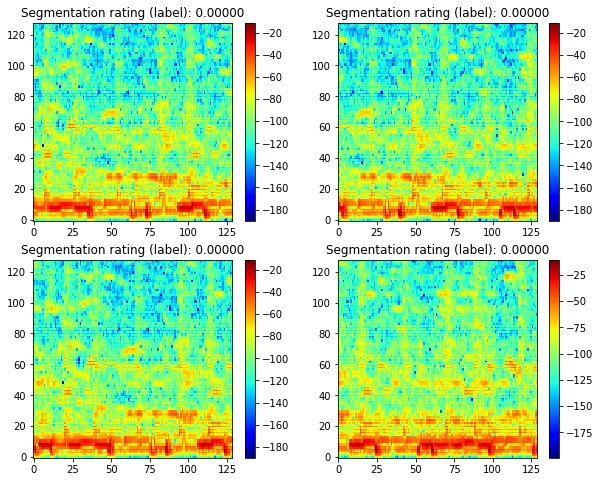

In [31]:
plt.rcParams['image.cmap'] = 'jet'
plt.figure()
for iPlot in range(1,5):
    plt.subplot(2,2,iPlot)
    samp = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[samp,0], origin="lower")
    plt.colorbar()
    plt.title("Segmentation rating (label): {0:1.5f}".format(y_train[samp,0]))
plt.show()

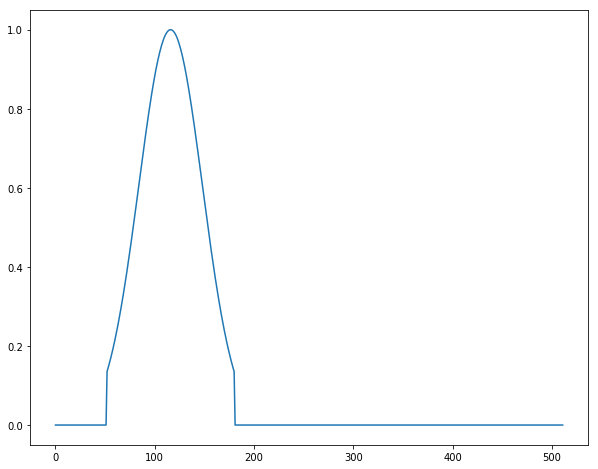

In [32]:
plt.plot(y_train)

In [10]:
# Import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD

# VGG-like convnet, from Keras examples, http://keras.io/examples/
model= Sequential()

reg_amount = 0.01

model.add(Convolution2D(
        16, 3, 3,
        border_mode='valid',
        input_shape=(1, 128, 129),
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(
        16, 3, 3,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(
        16, 3, 3,
        border_mode='valid',
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(
        16, 3, 3,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(
        256,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(
        1,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('linear'))

sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='msle', optimizer=sgd)

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [11]:
# plot the model
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

In [12]:
from keras.callbacks import ModelCheckpoint
# Callback for model checkpointing
checkpointer = ModelCheckpoint(filepath="./bindata/weights.hdf5", verbose=1, save_best_only=True)

# Callback for loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [13]:
history = LossHistory()

model.reset_states()

hist = model.fit(
    X_train, y_train,
    batch_size=32,
    nb_epoch=1,
    show_accuracy=True,
    verbose=1,
    callbacks=[checkpointer, history],
    validation_data=(X_val, y_val)
    )

Train on 512 samples, validate on 64 samples
Epoch 1/1
512/512 [==============================] - 104s - loss: 6.5082 - acc: 1.0000 - val_loss: 0.0986 - val_acc: 1.0000


In [ ]:
for weights in model.get_weights():
    print "===================================="
    print weights

In [ ]:
plt.plot(history.losses)

In [ ]:
import keras_net as kn

In [ ]:
kn.TRAIN_CAP = 256

hist = kn.main(
    num_epochs=1,
    n_songs_train=1,
    n_songs_val=1,
    n_songs_test=1,
    batch_size=256,
    learning_rate=0.0001,
    datadir='/home/tim/Projects/convnet-music-structure/salami-audio',
    salamidir='/home/tim/Projects/convnet-music-structure/salami-data-public',
    outputdir='/home/tim/Projects/convnet-music-structure/src/bindata',
    reg_amount=0.01
    )

In [14]:
whos

Variable             Type               Data/Info
-------------------------------------------------
Activation           type               <class 'keras.layers.core.Activation'>
BatchNormalization   type               <class 'keras.layers.norm<...>tion.BatchNormalization'>
Convolution2D        type               <class 'keras.layers.conv<...>olutional.Convolution2D'>
Dense                type               <class 'keras.layers.core.Dense'>
Dropout              type               <class 'keras.layers.core.Dropout'>
Flatten              type               <class 'keras.layers.core.Flatten'>
GstAppSink           GObjectMeta        <class 'audioread.gstdec.__main__.GstAppSink'>
GstAudioConvert      GObjectMeta        <class 'audioread.gstdec.<...>_main__.GstAudioConvert'>
GstBaseSink          GObjectMeta        <class 'audioread.gstdec.__main__.GstBaseSink'>
GstBaseTransform     GObjectMeta        <class 'audioread.gstdec.<...>main__.GstBaseTransform'>
GstURIDecodeBin      GObjectMeta    

In [23]:
# Test!
X_test = np.memmap(
    test['Xfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(test['Xshape'])
    )
y_test = np.memmap(
    test['yfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(test['yshape'])
    )

In [27]:
sid = test['sids'][0]

In [41]:
TRAIN_CAP = None
import threading

class DataGenerator(object):
    '''
    Generate minibatches from serialized data.
    '''
    def __init__(self, datadict, batch_size=32, shuffle=False, seed=None):
        self.lock = threading.Lock()
        self.data       = datadict
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.seed       = seed
        self = self.flow(
            datadict,
            batch_size=batch_size,
            shuffle=False,
            seed=None,
            save_to_dir=None,
            save_prefix="",
            save_format="jpeg")


    def next(self):
        # for python 2.x
        # Keep under lock only the mechainsem which advance the indexing of each batch
        # see # http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.flow_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        offsetmul = self.data['Xshape'][1] * self.data['Xshape'][2] * self.data['Xshape'][3]
        x_path = os.path.abspath(
            os.path.join(self.data['datadir'], self.data['Xfile'])
            )
        y_path = os.path.abspath(
            os.path.join(self.data['datadir'], self.data['yfile'])
            )
        bX = np.memmap(
            x_path,
            dtype='float32',
            mode='r',
            shape=(current_batch_size, self.data['Xshape'][1], self.data['Xshape'][2], self.data['Xshape'][3]),
            offset=current_index*offsetmul
            )
        bY = np.memmap(
            y_path,
            dtype='float32',
            mode='r',
            shape=(current_batch_size, 1),
            offset=current_index
            )
        return bX, bY

    def flow(self, datadict, batch_size=32, shuffle=False, seed=None,
             save_to_dir=None, save_prefix="", save_format="jpeg"):
        assert datadict['Xshape'][0] == datadict['yshape'][0]
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.flow_generator = self._flow_index(datadict['Xshape'][0], batch_size, shuffle, seed)
        return self

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):

        # Check cap
        if TRAIN_CAP:
            N = min(N, TRAIN_CAP)

        b = 0
        total_b = 0
        while 1:
            if b == 0:
                if seed is not None:
                    np.random.seed(seed + total_b)

                if shuffle:
                    index_array = np.random.permutation(N)
                else:
                    index_array = np.arange(N)

            current_index = (b * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
            else:
                current_batch_size = N - current_index

            if current_batch_size == batch_size:
                b += 1
            else:
                b = 0
            total_b += 1
            yield index_array[current_index: current_index + current_batch_size], current_index, current_batch_size



NameError: name 'outputdir' is not defined

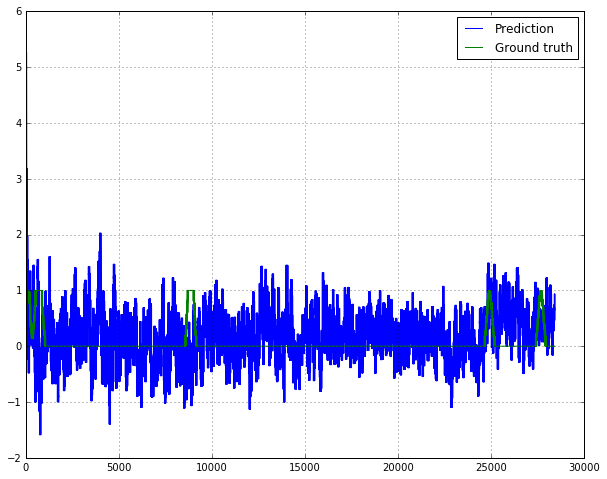

In [55]:
batch_size = 32

# TEST MODEL ###############################################################
test_batch_gen = DataGenerator(
    test,
    batch_size=batch_size,
    shuffle=False,
    seed=None
    )

n_batches = int(math.ceil(test['yshape'][0]/float(batch_size)))
y_pred = np.zeros((n_batches*batch_size, 1))
y_true = np.zeros((n_batches*batch_size, 1))
i_start = 0
for iBatch in xrange(n_batches):
    bX, by = test_batch_gen.next()
    n_batch = bX.shape[0]
    y_pred[i_start:i_start+n_batch] = np.array(model.predict_on_batch(bX))
    y_true[i_start:i_start+n_batch] = by[:]
    i_start += n_batch

plt.figure(3)
plt.plot(y_pred, label="Prediction")
plt.plot(y_true, label="Ground truth")
plt.grid()
plt.legend()
plt.savefig(
    os.path.abspath(os.path.join(outputdir, 'test.pdf')),
    bbox_inches='tight'
    )

plt.show()